# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
geo_data = pd.read_excel('geo.xlsx')
geo_comment_data = pd.read_excel('geo_comment.xlsx')

In [6]:
geo_data[: 10000].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 3 columns):
x                10000 non-null float64
y                10000 non-null float64
comment_class    10000 non-null int64
dtypes: float64(2), int64(1)
memory usage: 312.5 KB


In [7]:
geo_comment_data.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


Попробуем разбить на кластеры координаты.

In [8]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [16]:
algorithms = [
    AffinityPropagation(),
    KMeans(n_clusters=2),
    AgglomerativeClustering(n_clusters=2),
    DBSCAN(),
]

In [17]:
def get_descr(algo_name, y, y_pred, X):
    return "{}\nARI {:.2f}\nSilhouette {:.2f}".format(
        algo_name,
        adjusted_rand_score(y, y_pred),
        silhouette_score(X, y_pred)
    )

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y = geo_data[: 10000].copy().comment_class
X = geo_data[: 10000].copy().drop("comment_class", axis=1)
X_scaled = scaler.fit_transform(X)
# X_scaled = geo_data.copy().drop("comment_class", axis=1)
X_scaled[:, 0]

array([ 0.4408269 ,  0.4408269 ,  0.28314165, ...,  0.07916078,
        0.07916078,  0.07916078])

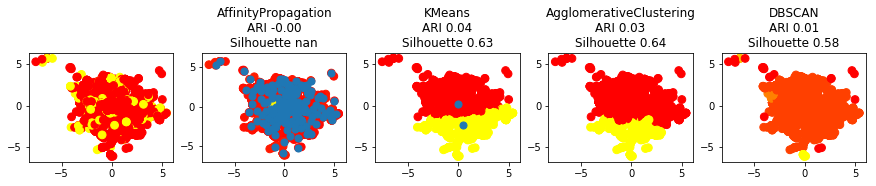

In [22]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2))
clusters_num = 3
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='autumn', s=60)
# axes[0].set_title(get_descr("Random", y, clusters_num, X_scaled))
for ax, algorithm in zip(axes[1:], algorithms):
    # кластеризуем и выводим картинку
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='autumn', s=60)
    ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, X_scaled))
    
    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)